# Plotting 

In [6]:
%load_ext lab_black

In [7]:
import collections
import json
import os
from itertools import product
from pathlib import Path
import sys
import pandas as pd
import numpy as np
from mne_bids.path import get_entities_from_fname
from natsort import natsorted
from rerf.rerfClassifier import rerfClassifier

# comparative classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    f1_score,
    roc_curve,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    brier_score_loss,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.utils import resample
from sklearn.calibration import calibration_curve

import dabest
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sys.path.append("../")
# functions related to the feature comparison experiment
from sample_code.io import read_participants_tsv
from sample_code.utils import _load_turbo, _plot_roc_curve

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def average_roc(fpr, tpr):
    """Compute average ROC statistics."""
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)

    n_splits = len(fpr)
    print(f"Computing average ROC over {n_splits} CV splits")
    for i in range(n_splits):
        interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(mean_fpr, interp_tpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    std_tpr = np.std(tprs, axis=0)
    return mean_fpr, tprs, aucs

In [9]:
def combine_patient_predictions(
    ytrues, ypred_probs, subject_groups, pat_predictions=None, pat_true=None
):
    if pat_predictions is None or pat_true is None:
        pat_predictions = collections.defaultdict(list)
        pat_true = dict()

    # loop through things
    for ytrue, ypred_proba, subject in zip(ytrues, ypred_probs, subject_groups):
        pat_predictions[subject].append(float(ypred_proba))

        if subject not in pat_true:
            pat_true[subject] = ytrue[0]
        else:
            if pat_true[subject] != ytrue[0]:
                raise RuntimeError("wtf subject should all match...")
    return pat_predictions, pat_true

In [10]:
from scipy.spatial.distance import cdist

# get line between optimum and clinical op point
def create_line(x1, x2, y1, y2, n_points=200):
    slope = (y2 - y1) / (x2 - x1)

    xs = np.linspace(x1, x2, n_points)
    ys = np.linspace(y1, y2, n_points)

    return xs, ys


def find_intersect_idx(x1s, y1s, x2s, y2s):
    """Help find intersection points between two curves."""
    euc_dists = []
    points = np.vstack((x2s, y2s)).T
    for idx, (x1, y1) in enumerate(zip(x1s, y1s)):
        point = np.array([x1, y1])[np.newaxis, :]
        dists = cdist(points, point)
        euc_dists.append(min(dists))
    return np.argmin(euc_dists)

# Define Data Directories

In [11]:
# set seed and randomness for downstream reproducibility
seed = 12345
random_state = 12345
np.random.seed(seed)

# proportion of subjects to use for training
train_size = 0.6

# classification model to use
clf_type = "mtmorf"

# BIDS related directories
bids_root = Path("/Users/adam2392/Dropbox/morf-study/")
# bids_root = Path("/home/adam2392/hdd/Dropbox/morf-study/")
deriv_path = bids_root / "derivatives"
source_path = bids_root / "sourcedata"

# metadata table
excel_fpath = source_path / "organized_clinical_datasheet_raw.xlsx"

# where to store the cross-validation indices to split patients on
intermed_fpath = Path(deriv_path)

# where to save results
study_path = Path(deriv_path) / "figures"

# feature names
feature_names = [
    "fragility",
]

# Read in the Participants.tsv File Containing Clinical Metadata

The participants.tsv file contains clinical metadata. Let's get the clinical success rate of our dataset
and total success/failure counts.

In [12]:
pat_df = read_participants_tsv(bids_root)
subjects = pat_df["participant_id"]
display(pat_df.head())

,participant_id,age,sex,hand,outcome,engel_score,ilae_score,date_follow_up,ethnicity,years_follow_up,site,clinical_complexity
0,sub-jh101,NaN,NaN,NaN,F,4.0,6.0,NaN,NaN,1.0,JHH,4.0
1,sub-jh102,NaN,NaN,NaN,NR,-1.0,-1.0,NaN,NaN,1.0,JHH,4.0
2,sub-jh103,NaN,NaN,NaN,F,4.0,6.0,NaN,NaN,1.0,JHH,3.0
3,sub-jh104,NaN,NaN,NaN,NR,-1.0,-1.0,NaN,NaN,1.0,JHH,3.0
4,sub-jh105,NaN,NaN,NaN,S,1.0,1.0,NaN,NaN,1.0,JHH,2.0


In [9]:
outcomes = []

# get a list of all the outcomes
for subj in np.unique(subjects):
    # use excel file to set various data points
    pat_row = pat_df[pat_df["participant_id"] == subj]
    if pat_row["outcome"].isnull().values.any():
        continue
    outcome = pat_row["outcome"].values[0]
    outcomes.append(outcome)
print(outcomes)

['F', 'NR', 'F', 'NR', 'S', 'NR', 'S', 'F', 'S', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'F', 'S', 'F', 'F', 'F', 'F', 'F', 'F', 'NR', 'F', 'S', 'S', 'NR', 'S', 'S', 'S', 'F', 'NR', 'F', 'S', 'F', 'S', 'S', 'S', 'S', 'F', 'S', 'S', 'S', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'S', 'S', 'S', 'S', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'S', 'F', 'F', 'F', 'F', 'F', 'F', 'S', 'F', 'S', 'S', 'F', 'F', 'S', 'S', 'NR', 'S', 'S', 'S', 'S', 'S', 'NR', 'S', 'S']


In [10]:
n_success = len(np.argwhere(np.array(outcomes) == "S"))
clinical_sensitivity = n_success / len(outcomes)
clinical_fpr = (len(outcomes) - n_success) / len(outcomes)

print(f"Clinical sensitivity: {clinical_sensitivity}")
print(f"Clinical False Positive Rate: {clinical_fpr}")

Clinical sensitivity: 0.44554455445544555
Clinical False Positive Rate: 0.5544554455445545


# Plotting Comparisons

In [11]:
def average_roc(fpr, tpr):
    """Compute average ROC statistics."""
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)

    n_splits = len(fpr)
    print(f"Computing average ROC over {n_splits} CV splits")
    for i in range(n_splits):
        #         print(i, len(fpr[i]), len(tpr[i]))
        interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(mean_fpr, interp_tpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    std_tpr = np.std(tprs, axis=0)
    return mean_fpr, tprs, aucs

In [12]:
# identifying strings for each feature representation of the data
feature_name = "fragility"

## Setup for run
names = {
    "Log. Reg": "blue",
    # "Lin. SVM": "firebrick",
    "SVM": "purple",
    #     "kNN": "black",
    "RF": "#f86000",
    "MLP": "green",
    "cnn": "magenta",
    "xgb": "black",
    "dummby": "teal",
    "srerf": "red",
    "mtmorf": "orange",
}

clf_type = "mtmorf"

# study_path = deriv_path / "study"
study_path = Path("/Users/adam2392/Dropbox/morf-study/")
print(study_path)

/Users/adam2392/Dropbox/morf-study


In [13]:
# dictionary data structure to hold all the CV experiment results
nested_scores_feature = dict()

for clf_name in names:
    # nested CV estimators
    nested_scores_search_pattern = f"study_cv_scores_{clf_name}_{feature_name}_*.json"
    nested_scores = None

    # get all json files that follow that search pattern
    fpaths = (
        study_path
        / "fragility retrospective study - comparison_classifiers"
        / "clf-train-vs-test"
    ).glob(nested_scores_search_pattern)

    fpaths = natsorted(fpaths)
    for idx, json_fpath in enumerate(fpaths):
        with open(json_fpath, "r") as fin:
            _nested_scores = json.load(fin)

        # either append to the nested dictionary, or create it
        # some magic done to cast numbers in case they were saved in different formats
        if nested_scores is None:
            for key, val in _nested_scores.items():
                if key in [
                    "validate_ytrue",
                    "validate_fpr",
                    "validate_tpr",
                    "validate_pat_true",
                    "validate_pat_predictions",
                ]:
                    while len(val) <= 10 and (
                        isinstance(val[0], list) or isinstance(val[0], dict)
                    ):
                        #                         print([len(x) for x in val])
                        val = val[-1]
                #                         print(len(val))
                else:
                    continue
            nested_scores = _nested_scores
        else:
            for key, val in _nested_scores.items():
                #                 if key == [
                #                     "validate_ytrue",
                #                 ]:
                #                     val = val[0]
                #                     for idx, y in enumerate(val):
                #                         val[idx] = y[0]
                if key in [
                    "validate_ytrue",
                    "validate_fpr",
                    "validate_tpr",
                    "validate_pat_true",
                    "validate_pat_predictions",
                ]:
                    while len(val) <= 10 and (
                        isinstance(val[0], list) or isinstance(val[0], dict)
                    ):
                        #                         print([len(x) for x in val])
                        val = val[-1]
                #                         print(len(val))
                nested_scores[key].append(np.array(val).squeeze())
    print(f"There should be 10 total CV for {clf_name}. We found {len(fpaths)}")
    nested_scores_feature[clf_name] = nested_scores

There should be 10 total CV for Log. Reg. We found 10
There should be 10 total CV for SVM. We found 10
There should be 10 total CV for RF. We found 10
There should be 10 total CV for MLP. We found 10
There should be 10 total CV for cnn. We found 10
There should be 10 total CV for xgb. We found 10
There should be 10 total CV for dummby. We found 10
There should be 10 total CV for srerf. We found 10
There should be 10 total CV for mtmorf. We found 10


In [14]:
auc_feat_names = []
auc_feat_scores = []

for name, nested_scores in nested_scores_feature.items():
    print(name)
    # summarize the boot-strapped samples
    fprs, tprs = nested_scores["validate_fpr"], nested_scores["validate_tpr"]
    # aucs = [auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)]
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)

    auc_feat_names.append(name)
    auc_feat_scores.append(np.mean(aucs))

auc_sorted_inds = np.argsort(auc_feat_scores)[::-1]
print(np.array(auc_feat_names)[auc_sorted_inds])

Log. Reg
Computing average ROC over 10 CV splits
SVM
Computing average ROC over 10 CV splits
RF
Computing average ROC over 10 CV splits
MLP
Computing average ROC over 10 CV splits
cnn
Computing average ROC over 10 CV splits
xgb
Computing average ROC over 10 CV splits
dummby
Computing average ROC over 10 CV splits
srerf
Computing average ROC over 10 CV splits
mtmorf
Computing average ROC over 10 CV splits
['mtmorf' 'srerf' 'RF' 'xgb' 'Log. Reg' 'SVM' 'cnn' 'MLP' 'dummby']


In [15]:
# store all AUCs and Average Precision metrics
feature_aucs = dict()
feature_prs = dict()
feature_pred_names = []
feature_pred_probs = []
feature_pred_subs = []

# show some summary statements?
verbose = False

Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits


<ipython-input-20-5e190ec582a7>:218: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


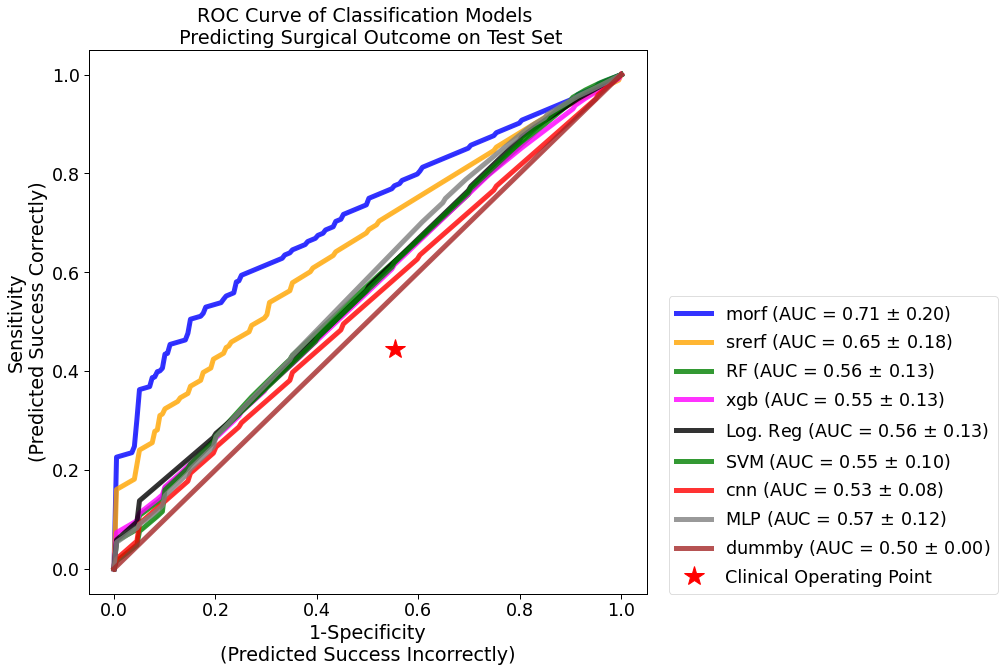

In [20]:
sns.set_context("paper", font_scale=2.0)

# figure to show ROC
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# color scheme
colors = [
    "blue",
    "orange",
    "green",
    "magenta",
    "black",
    "green",
    "red",
    "gray",
    "brown",
    "teal",
    "purple",
]

# for idx, (feature_name, nested_scores) in enumerate(nested_scores_feature.items()):
for idx in range(len(auc_feat_names)):
    # extract the feature name for plotting
    feature_name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]

    # get the test set performances for this feature
    nested_scores = nested_scores_feature[feature_name]

    # extract the predicted probability of success, the true outcomes
    # for each 10 fold CV
    pat_predict_proba = nested_scores["validate_pat_predictions"]
    pat_true = nested_scores["validate_pat_true"]

    # initialize lists to store certain metrics we want to keep track of
    fprs = []
    tprs = []
    accs = []
    aps = []
    npvs = []
    ppvs = []
    ratio_succ = []
    ratio_fail = []
    n_succ = []
    n_fail = []

    # for visual sake only show the top 3 performing based on average AUC
    #     if idx > 3:
    #         idx = 4
    color = colors[idx]

    # loop through each CV fold (10 in total)
    for jdx in range(len(pat_true)):
        # in case data was stored in different formats, just pull them out
        # byproduct of saving w/ different encoding...
        if isinstance(pat_true[jdx], dict):
            pat_trues = pat_true[jdx]
            pat_predicts = pat_predict_proba[jdx]
        else:
            pat_trues = pat_true[jdx].item()
            pat_predicts = pat_predict_proba[jdx].item()

        # keep each patient's probability of success prediction, true outcome and list
        # of subjects in the test dataset
        pat_proba = []
        pat_y = []
        subjects = []
        for patient, pat_y_true in pat_trues.items():
            pat_probas = pat_predicts[patient]
            pat_mean_proba = np.mean(np.array(pat_probas).squeeze())

            pat_proba.append(pat_mean_proba)
            pat_y.append(pat_y_true)
            subjects.append(patient)

        # set the patient predictions based on the success probability prediction
        pat_predictions = np.where(np.array(pat_proba) > 0.5, 1, 0)

        # compute a balanced accuracy score of the predicted outcomes vs true outcomes
        acc = balanced_accuracy_score(pat_y, pat_predictions)

        # compute the number of failures/success per CV fold and the ratio of each
        n_true_succ = len(
            [y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 1]
        )
        n_true_fail = len(
            [y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 0]
        )
        num_fail = len(
            [
                y_
                for y_, ytrue_ in zip(pat_predictions, pat_y)
                if y_ == ytrue_
                if ytrue_ == 0
            ]
        )
        num_success = len(
            [
                y_
                for y_, ytrue_ in zip(pat_predictions, pat_y)
                if y_ == ytrue_
                if ytrue_ == 1
            ]
        )
        ratio_fail.append(num_fail / n_true_fail)
        ratio_succ.append(num_success / n_true_succ)
        n_fail.append(n_true_fail)
        n_succ.append(n_true_succ)

        # create the roc curve on this fold
        fpr, tpr, thresholds = roc_curve(pat_y, pat_proba)
        fprs.append(fpr)
        tprs.append(tpr)
        accs.append(acc)

        # store the subjects, predicted probabilities and feature names
        feature_pred_subs.extend(subjects)
        feature_pred_probs.extend(pat_proba)
        feature_pred_names.extend([feature_name] * len(pat_proba))

    ytrues, ypreds = (
        nested_scores["validate_ytrue"],
        nested_scores["validate_ypred_prob"],
    )
    if verbose:
        ### Now compute statistics for summary, such as accuracies, f1scores,
        accs = []
        f1s = []
        for ytrue, ypred in zip(ytrues, ypreds):
            ytrue = np.array(ytrue).squeeze()
            ypred = np.array(ypred).squeeze()
            ypred = np.array(ypred) > 0.5
            acc = balanced_accuracy_score(ytrue, ypred)
            f1score = f1_score(ytrue, ypred)
            accs.append(acc)
            f1s.append(f1score)

        print(f"\n\n{feature_name}")
        print(f"Balanced accuracy score: {np.mean(accs):.2f} +/- {np.std(accs):.2f}")
        print(f"F1 score: {np.mean(f1s):.2f} +/- {np.std(f1s):.2f}")
        print(f"Sensitivity: {youden_point[1]} and FPR: {youden_point[0]}")
        print("Improvement in FPR: ", np.round(youden_point[0] - clinical_fpr, 2))
        print(
            "Improvement in TPR: ", np.round(youden_point[1] - clinical_sensitivity, 2)
        )
        print(
            "Total distance: ",
            np.linalg.norm(
                (youden_point[0] - clinical_fpr, youden_point[1] - clinical_sensitivity)
            ),
        )
        print(f"Average Preicions: {np.mean(aps):.3f} +/- {np.std(aps):.3f}")
        print(f"Average NPVS: {np.mean(npvs):.3f} +/- {np.std(npvs):.3f}")
        print(f"Average PPVS: {np.mean(ppvs):.3f} +/- {np.std(ppvs):.3f}")
        print(
            f"Average failed ratio: {np.mean(ratio_fail):.3f} +/- {np.std(ratio_fail):.3f}"
        )
        print(
            f"Average success ratio: {np.mean(ratio_succ):.3f} +/- {np.std(ratio_succ):.3f}"
        )

    # compute the average ROC curve from the above loop over nested CV
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)

    # compute the avg/std of the AUC statistic
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    if feature_name == "mtmorf":
        feature_name = "morf"
    #     elif feature_name == 'srerf':
    #         continue
    feature_aucs[feature_name] = aucs

    # actually plot the ROC curve
    ax = _plot_roc_curve(
        mean_tpr,
        mean_fpr,
        mean_auc=mean_auc,
        std_auc=std_auc,
        label=feature_name,
        ax=ax,
        color=color,
        plot_chance=False,
    )

    # plot youden point on the curve
    xs, ys = create_line(clinical_fpr, 0, clinical_sensitivity, 1)
    youden_idx = find_intersect_idx(mean_fpr, mean_tpr, xs, ys)
    youden_point = (mean_fpr[youden_idx], mean_tpr[youden_idx])
#     ax.plot(
#         youden_point[0],
#         youden_point[1],
#         marker="*",
#         color=color,
#         markersize=20,
#         linestyle="None",
#     )

######## format the ROC curve figure ########
ax.set(
    ylabel="Sensitivity\n(Predicted Success Correctly)",
    xlabel="1-Specificity\n(Predicted Success Incorrectly)",
    title="ROC Curve of Classification Models \n Predicting Surgical Outcome on Test Set",
    #     xlim=[0, 0.05],
    #     ylim=[0.4, 1],
)
# plot clinical point
ax.plot(
    clinical_fpr,
    clinical_sensitivity,
    marker="*",
    color="red",
    markersize=20,
    linestyle="None",
    label="Clinical Operating Point",
)

fig.tight_layout()
ax.legend(
    #     ncol=2,
    loc=(1.04, 0)
)

# save figure to disc or not?
fig.savefig(
    study_path / f"morf_vs_classifiers_quantilefeatures.pdf", bbox_inches="tight"
)

## Compare the AUC per feature

First, we'll construct a dataframe of each of the 10 folds and features considered.

Then, well create a plot of the AUCs per feature.

Next, we'll evaluate the statistics of this performance. Note that AUC is a metric for us to measure how well each feature represents the underlying epileptic network based on our classification experiment setup. So the higher the AUC distributions are, the better. 

We analyze how much better the predictions are by comparing the 

In [21]:
feature_aucs_df = pd.DataFrame.from_dict(feature_aucs)
feature_aucs_df["id_col"] = np.arange(10)

display(feature_aucs_df.head())

# melt the dataframe, so it can be plotted using seaborn
feature_aucs_df = pd.melt(
    feature_aucs_df, id_vars="id_col", var_name="classifier", value_name="auc"
)
# display
feature_aucs_df.columns = [
    x.capitalize() if x in ["classifier"] else x.upper()
    for x in feature_aucs_df.columns
]
feature_aucs_df["Classifier"] = feature_aucs_df["Classifier"].str.capitalize()
display(feature_aucs_df.head())

,morf,srerf,RF,xgb,Log. Reg,SVM,cnn,MLP,dummby,id_col
0,0.899884,0.901817,0.924623,0.931774,0.926556,0.831852,0.779474,0.874372,0.5,0
1,0.391307,0.458413,0.458415,0.452742,0.608693,0.547258,0.500000,0.568051,0.5,1
2,0.921197,0.500000,0.609846,0.458337,0.541663,0.539772,0.500000,0.458337,0.5,2
3,0.500000,0.847608,0.454634,0.500000,0.500000,0.456525,0.500000,0.543475,0.5,3
4,0.844221,0.571425,0.500000,0.535712,0.500000,0.535712,0.500000,0.464288,0.5,4


,ID_COL,Classifier,AUC
0,0,Morf,0.899884
1,1,Morf,0.391307
2,2,Morf,0.921197
3,3,Morf,0.500000
4,4,Morf,0.844221


In [22]:
# map feature names to short-hand
feature_aucs_df["Classifier"] = [
    x.replace("coherence", "coh")
    .replace("degree", "deg")
    .replace("centrality", "cent")
    .replace("Correlation", "Corr")
    for x in feature_aucs_df["Classifier"]
]

order = (
    feature_aucs_df.groupby("Classifier")
    .median()
    .sort_values(by="AUC", ascending=False)
)
print(order.index.tolist())

['Morf', 'Mlp', 'Svm', 'Srerf', 'Log. reg', 'Rf', 'Xgb', 'Cnn', 'Dummby']


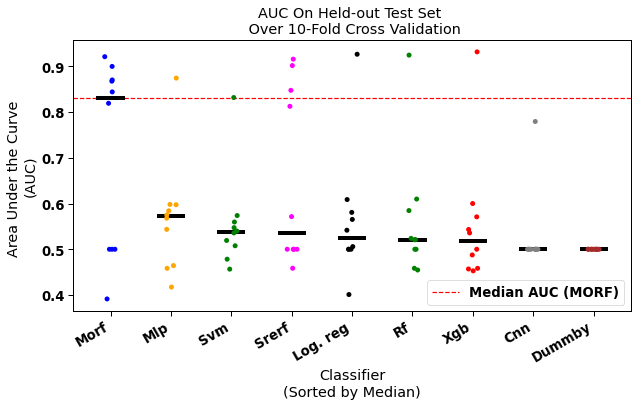

In [29]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["figure.titleweight"] = "bold"

sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 5))
# sns.boxplot(
#     x="Classifier",
#     y="AUC",
#     order=order.index,
#     data=feature_aucs_df,
#     ax=ax,
#     color="gray",
# )
sns.stripplot(
    x="Classifier",
    y="AUC",
    order=order.index,
    data=feature_aucs_df,
    ax=ax,
    palette=colors,
)
ax.axhline(
    feature_aucs_df[feature_aucs_df["Classifier"] == "Morf"]["AUC"].median(),
    color="red",
    ls="--",
    label="Median AUC (MORF)",
)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, ha="right", rotation=30)
ax.legend()
ax.set(
    title="AUC On Held-out Test Set \n Over 10-Fold Cross Validation",
    xlabel="Classifier\n(Sorted by Median)",
    ylabel="Area Under the Curve \n(AUC)",
)

# Select which box you want to change
# mybox = ax.artists[0]

# # Change the appearance of that box
# mybox.set_facecolor("red")
# mybox.set_edgecolor("black")
# mybox.set_linewidth(3)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = feature_aucs_df
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["Classifier"] == sample_name]["AUC"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=4,
        color="k",
    )

# figpath = Path(figdir) / f'figure4-discriminationandprecision/'
fname = f"delta_auc_plot_morf_vs_classifiers_quantilefeatures.pdf"
fig.savefig(study_path / fname, bbox_inches="tight")

# Compute Effect Size Differences

In [63]:
df = df.pivot(index="ID_COL", columns="Classifier", values="AUC")
df = df.reset_index()

In [64]:
display(df)

Classifier,ID_COL,Cnn,Dummby,Log. reg,Mlp,Morf,Rf,Srerf,Svm,Xgb
0,0,0.779474,0.5,0.926556,0.874372,0.899884,0.924623,0.901817,0.831852,0.931774
1,1,0.500000,0.5,0.608693,0.568051,0.391307,0.458415,0.458413,0.547258,0.452742
2,2,0.500000,0.5,0.541663,0.458337,0.921197,0.609846,0.500000,0.539772,0.458337
3,3,0.500000,0.5,0.500000,0.543475,0.500000,0.454634,0.847608,0.456525,0.500000
4,4,0.500000,0.5,0.500000,0.464288,0.844221,0.500000,0.571425,0.535712,0.535712
5,5,0.500000,0.5,0.565215,0.597351,0.870330,0.520791,0.500000,0.573721,0.570888
6,6,0.500000,0.5,0.505768,0.598078,0.500000,0.584617,0.915829,0.519228,0.456859
7,7,0.500000,0.5,0.580613,0.417310,0.819289,0.521057,0.500000,0.559614,0.599997
8,8,0.500000,0.5,0.500000,0.584118,0.500000,0.500000,0.812650,0.478264,0.543260
9,9,0.500000,0.5,0.400956,0.575237,0.867638,0.523806,0.500000,0.507619,0.487531


In [65]:
print(df.columns)

Index(['ID_COL', 'Cnn', 'Dummby', 'Log. reg', 'Mlp', 'Morf', 'Rf', 'Srerf',
       'Svm', 'Xgb'],
      dtype='object', name='Classifier')


In [66]:
feature_dabest = dabest.load(
    df,
    #                                  x='Classifier', y='AUC',
    idx=["Morf", "Mlp"],
    id_col="ID_COL",
    resamples=200,
    paired=True,
)

In [67]:
feature_dabest.cohens_d

/Users/adam2392/opt/miniconda3/envs/eztrack/lib/python3.8/site-packages/dabest/_classes.py:774: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="lower",
/Users/adam2392/opt/miniconda3/envs/eztrack/lib/python3.8/site-packages/dabest/_classes.py:779: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="upper",


DABEST v0.3.0
             
Good evening!
The current time is Thu Mar 25 23:32:02 2021.

The paired Cohen's d between Morf and Mlp is -0.83 [95%CI -2.32, 0.102].
The p-value of the two-sided permutation t-test is 0.089. 

200 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [69]:
display(feature_dabest.cohens_d.statistical_tests)

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Morf,Mlp,10,10,Cohen's d,True,-0.829754,95,-2.317151,0.102003,0.089,0.193359,14.0,0.093382,1.876126


done


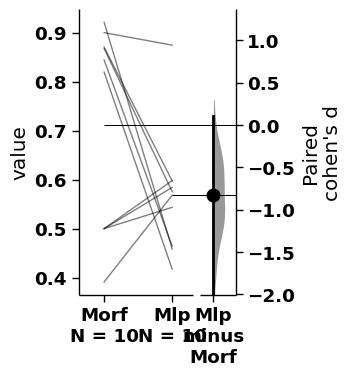

In [68]:
feature_dabest.cohens_d.plot()
print("done")